In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib 
from matplotlib import pyplot as plt
import gc
import multiprocessing as mp
from multiprocessing import Process, Queue
queue = Queue()
import random
from matplotlib.pyplot import figure
import math
from sklearn.model_selection import train_test_split

In [ ]:
def read_df(file_title,house_nb):
    try:
        df=pd.read_table(file_title, sep="," )
        df.columns = ["time","consumption"]
        try:
            df['time'] = pd.to_datetime(df['time'],unit='s')
        except:
            df['time'] = pd.to_datetime(df['time'])
        df.index= df.time
        df = df.sort_index()
        df.reset_index(drop=True, inplace=True)
        return (df,house_nb)
    except:
        return(None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Redd_fridges={}
for i in [1,2,3,5,6]:
    Redd_fridges[i]=read_df("drive/MyDrive/Resampled_Redd/house_"+str(i)+".csv",i)[0]

In [ ]:
pool = mp.Pool(processes = 3)
result=pool.starmap(read_df,(("drive/MyDrive/Refit_Resampled/fridge_freezer/house_"+str(i+1)+".csv",i+1) for i in range(21)))
Refit_fridge_freezers={}
for i in range(len(result)):
    if result[i]!=None:
        Refit_fridge_freezers[result[i][1]]=result[i][0]

In [ ]:
pool = mp.Pool(processes = 3)
result=pool.starmap(read_df,(("drive/MyDrive/Refit_Resampled/fridge/house_"+str(i+1)+".csv",i+1) for i in range(21)))
Refit_fridges={}
for i in range(len(result)):
    if result[i]!=None:
        Refit_fridges[result[i][1]]=result[i][0]

In [ ]:
def csv_to_activations(file_title):
    df=pd.read_table(file_title, sep="," )
    df = df[['beginning', 'end','label']]
    activation = [tuple(x[0:2]) for x in df.to_numpy()]
    activation_type = [x[2] for x in df.to_numpy()]
    return(activation,activation_type)

In [ ]:
Refit_fridge_freezer_activation_type={}
Refit_fridge_freezer_activations={}
for house_nb in range(22):
    try:
        Refit_fridge_freezer_activations[house_nb]=csv_to_activations("drive/MyDrive/fridge_freezer_resampled/house_"+str(house_nb))[0]
        Refit_fridge_freezer_activation_type[house_nb]=csv_to_activations("drive/MyDrive/fridge_freezer_resampled/house_"+str(house_nb))[1]
    except:
        None

In [ ]:
Refit_fridge_activation_type={}
Refit_fridge_activations={}
for house_nb in range(22):
    try:
        Refit_fridge_activations[house_nb]=csv_to_activations("drive/MyDrive/fridge_resampled/house_"+str(house_nb))[0]
        Refit_fridge_activation_type[house_nb]=csv_to_activations("drive/MyDrive/fridge_resampled/house_"+str(house_nb))[1]
    except:
        None

In [ ]:
Redd_activation_type={}
Redd_activations={}
for house_nb in [1,2,3,5,6]:
    Redd_activations[house_nb]=csv_to_activations("drive/MyDrive/redd_oversampled_labeled_activations_"+str(house_nb)+".csv")[0]
    Redd_activation_type[house_nb]=csv_to_activations("drive/MyDrive/redd_oversampled_labeled_activations_"+str(house_nb)+".csv")[1]

In [ ]:
def normal_anomolous(activations,activation_type,house_nb):
    normal_activations=[]
    anomolous_activations=[]
    for i in range(len(activations)):
        if activation_type[i]==0:
            normal_activations.append(activations[i])
        else:
            anomolous_activations.append(activations[i])
    return(normal_activations,anomolous_activations,house_nb)

In [ ]:
Refit_fridge_freezer_normal_activations={}
Refit_fridge_freezer_anomolous_activations={}
for house_nb in Refit_fridge_freezer_activations.keys():
    result=normal_anomolous(Refit_fridge_freezer_activations[house_nb],Refit_fridge_freezer_activation_type[house_nb],house_nb)
    Refit_fridge_freezer_normal_activations[house_nb]=result[0]
    Refit_fridge_freezer_anomolous_activations[house_nb]=result[1]

In [ ]:
Refit_fridge_normal_activations={}
Refit_fridge_anomolous_activations={}
for house_nb in Refit_fridge_activations.keys():
    result=normal_anomolous(Refit_fridge_activations[house_nb],Refit_fridge_activation_type[house_nb],house_nb)
    Refit_fridge_normal_activations[house_nb]=result[0]
    Refit_fridge_anomolous_activations[house_nb]=result[1]

In [ ]:
Redd_normal_activations={}
Redd_anomolous_activations={}
for house_nb in [1,2,3,5,6]:
    result=normal_anomolous(Redd_activations[house_nb],Redd_activation_type[house_nb],house_nb)
    Redd_normal_activations[house_nb]=result[0]
    Redd_anomolous_activations[house_nb]=result[1]

In [ ]:
def bigger_activations_ffill(df,activation,windowlength):
    begin=activation[0]
    end=activation[1]
    new_activation=[]
    windowlength=windowlength*6
    nb_full_activations=math.ceil((end-begin)/windowlength)
    for i in range (nb_full_activations):
        new_activation.append(list(df.consumption.iloc[begin+i*windowlength:begin+(i+1)*windowlength]))
    return (new_activation)

In [ ]:
def small_activations_ffill(df,activation,windowlength):
    begin=activation[0]
    end=activation[1]
    difference=windowlength*6+begin-end
    new_activation=[]
    if ((len(df.index)-activation[1])>=difference):
        new_activation=list(df.consumption.iloc[begin:end+difference])
    else:
        new_activation=list(df.consumption.iloc[begin-difference:end])
    return(new_activation)

In [ ]:
def get_x_y(df,activations,activation_type,windowlength):
    x=[]
    y=[]
    for i in range(len(activations)):
        activation=activations[i]
        label=activation_type[i]
        if (activation[1]-activation[0])<=windowlength*6:
            x.append(small_activations_ffill(df,activation,windowlength))
            y.append(label)
        else:
            x.extend(bigger_activations_ffill(df,activation,windowlength))
            while(len(y)<len(x)):
                y.append(label)
    return(x,y)

In [ ]:
test_train_fridge_houses=list(Refit_fridge_activations.keys())
test_train_fridge_freezer_houses=list(Refit_fridge_freezer_activations.keys())
print(Refit_fridge_freezer_activations.keys())
test_train_redd=list(Redd_activations.keys())

test_train_fridge_houses.remove(11)
test_train_fridge_freezer_houses.remove(11)
test_train_redd.remove(5)
evaluation_houses=[11]
evaluation_houses_redd=[5]

test_train_fridge_freezer_houses.remove(3)
test_train_fridge_freezer_houses.remove(16)
test_train_toadd_freezer=[3,16]

dict_keys([2, 3, 4, 5, 9, 11, 12, 15, 16, 17, 18, 19, 21])


In [ ]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_x_y,((Refit_fridges[i],Refit_fridge_activations[i],Refit_fridge_activation_type[i],45) for i in test_train_fridge_houses))

In [ ]:
x_total_refit=[]
y_total_refit=[]
for i in range(len(result)):
    x_total_refit.extend(result[i][0])
    y_total_refit.extend(result[i][1])

In [ ]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_x_y,((Refit_fridge_freezers[i],Refit_fridge_freezer_activations[i],Refit_fridge_freezer_activation_type[i],45) for i in test_train_fridge_freezer_houses))

In [ ]:
for i in range(len(result)):
    x_total_refit.extend(result[i][0])
    y_total_refit.extend(result[i][1])

In [ ]:
pool = mp.Pool(processes = 3)
result=pool.starmap(get_x_y,((Redd_fridges[i],Redd_activations[i],Redd_activation_type[i],45) for i in test_train_redd))

In [ ]:
x_total_redd=[]
y_total_redd=[]
for i in range(len(result)):
    x_total_redd.extend(result[i][0])
    y_total_redd.extend(result[i][1])

In [ ]:
x_normal_redd=[]
x_anomolous_redd=[]
nb_normal=0
nb_abnormal=0
for i in range(len(y_total_redd)):
    if y_total_redd[i]==0:
        x_normal_redd.append(x_total_redd[i])
        nb_normal+=1
    else:
        x_anomolous_redd.append(x_total_redd[i])
        nb_abnormal+=1
print(nb_normal)
print(len(x_normal_redd))
print(nb_abnormal)
print(len(x_anomolous_redd))

1631
1631
1844
1844


In [ ]:
x_normal=[]
x_anomolous=[]
nb_normal=0
nb_abnormal=0
for i in range(len(y_total_refit)):
    if y_total_refit[i]==0:
        x_normal.append(x_total_refit[i])
        nb_normal+=1
    else:
        x_anomolous.append(x_total_refit[i])
        nb_abnormal+=1
print(nb_normal)
print(len(x_normal))
print(nb_abnormal)
print(len(x_anomolous))

161731
161731
198000
198000


In [ ]:
def oversampled_normal(x_normal,x_anomolous):
    normal_nb=len(x_normal)
    abnormal_nb=len(x_anomolous)
    oversampling_nb=abnormal_nb-normal_nb
    oversampled_list=[]
    for i in range(0,oversampling_nb):
        oversampled_list.append(random.choice(x_normal))
    return (oversampled_list)

In [ ]:
x_total_refit.extend(oversampled_normal(x_normal,x_anomolous))
while(len(y_total_refit)<len(x_total_refit)):
    y_total_refit.append(0)

In [ ]:
x_total_redd.extend(oversampled_normal(x_normal_redd,x_anomolous_redd))
while(len(y_total_redd)<len(x_total_redd)):
    y_total_redd.append(0)

In [ ]:
x_total_refit=np.array(x_total_refit)
y_total_refit=np.array(y_total_refit)

In [ ]:
x_total_refit[0]

array([  0.,   0., 972.,  93.,  85.,  85.,  85.,  86.,  85.,  84.,  85.,
        84.,  84.,  84.,  84.,  84.,  84.,  84.,  83.,  84.,  84.,  83.,
        83.,  83.,  84.,  84.,  83.,  84.,  84.,  84.,  83.,  84.,  84.,
        84.,  84.,  84.,  84.,  84.,  83.,  83.,  83.,  83.,  84.,  83.,
        83.,  83.,  83.,  83.,  83.,  82.,  82.,  82.,  80.,  80.,  81.,
        81.,  81.,  80.,  80.,  80.,  80.,  80.,  80.,  79.,  79.,  80.,
        79.,  79.,  79.,  79.,  78.,  78.,  78.,  78.,  78.,  77.,  77.,
        77.,  78.,  77.,  76.,  77.,  76.,  76.,  76.,  76.,  76.,  75.,
        76.,  76.,  75.,  74.,  74.,  75.,  74.,  74.,  74.,  74.,  74.,
        74.,  74.,  73.,  74.,  73.,  73.,  73.,  73.,  73.,  73.,  73.,
        73.,  73.,  73.,  73.,  72.,  73.,  72.,  72.,  72.,  72.,  72.,
        72.,  72.,  71.,  71.,  71.,  72.,  71.,  71.,  72.,  71.,  71.,
        71.,  71.,  71.,  71.,  71.,  71.,  71.,  71.,  70.,  70.,  71.,
        71.,  71.,  70.,  70.,  69.,  69.,  70.,  7

In [ ]:
x_total_redd=np.array(x_total_redd)
y_total_redd=np.array(y_total_redd)

In [ ]:
x_train_refit, x_test_refit, y_train_refit, y_test_refit = train_test_split(x_total_refit, y_total_refit, test_size=0.3)

In [ ]:
x_train_redd, x_test_redd, y_train_redd, y_test_redd = train_test_split(x_total_redd, y_total_redd, test_size=0.3)

In [ ]:
x_train=np.concatenate((x_train_refit, x_train_redd), axis=0)
y_train=np.concatenate((y_train_refit, y_train_redd), axis=0)
x_test=np.concatenate((x_test_refit, x_test_redd), axis=0)
y_test=np.concatenate((y_test_refit, y_test_redd), axis=0)

In [ ]:
x_train=np.array(x_train)
x_test=np.array(x_test)

In [ ]:
y=y_train
y_train=[]
for i in range(len(y)):
    y_train.append(np.array([y[i]]))
y_train=np.array(y_train)

In [ ]:
y=y_test
y_test=[]
for i in range(len(y)):
    y_test.append(np.array([y[i]]))
y_test=np.array(y_test)

In [ ]:
y_test.shape

(119927, 1)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(279829, 270)
(119927, 270)
(279829, 1)
(119927, 1)


In [ ]:
x_train[0]

array([ 0.,  0., 51., 51., 48., 44., 37., 38., 39., 39., 38., 37., 37.,
       38., 40., 41., 40., 39., 39., 42., 44., 44., 43., 43., 42., 43.,
       44., 43., 43., 43., 44., 44., 44., 44., 44., 44., 44., 45., 45.,
       44., 45., 45., 45., 45., 45., 45., 45., 44., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 44., 44., 45., 45., 44., 44., 44., 44., 44., 44.,
       44., 20., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [ ]:
y_train[0]

array([0])

In [ ]:
mean=x_train.mean()
std=x_train.std()

In [ ]:
std

77.55364250681977

In [ ]:
x_train=x_train-mean
x_test=x_test-mean

In [ ]:
print(int(x_train.mean()))
print(int(x_test.mean()))

0
0


In [ ]:
x_train=x_train/std
x_test=x_test/std

In [ ]:
print(x_train.std())
print(x_test.std())

0.9999999999999967
0.9956333591480357


In [ ]:
x_train

array([[-0.79011207, -0.79011207, -0.13250273, ..., -0.79011207,
        -0.79011207, -0.79011207],
       [-0.79011207, -0.79011207,  0.67983823, ..., -0.79011207,
        -0.79011207, -0.79011207],
       [-0.76432347, -0.76432347,  0.91193564, ..., -0.76432347,
        -0.76432347, -0.76432347],
       ...,
       [-0.79011207, -0.79011207,  0.91193564, ..., -0.77721777,
        -0.77721777, -0.77721777],
       [-0.79011207, -0.79011207, 11.66578257, ...,  0.77009833,
         0.71852113,  0.74430973],
       [-0.77721777, -0.77721777,  0.96351284, ...,  0.70562683,
         0.70562683,  0.71852113]])

In [ ]:
print(x_train)
print(y_train)

[-0.79240738 -0.79240738  1.13349084 ... -0.71485443 -0.71485443
 -0.71485443]
[0 1 1 ... 1 0 0]


<ipython-input-46-7850df578bdc>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


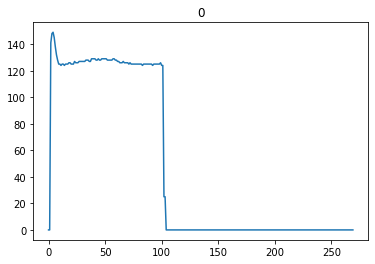

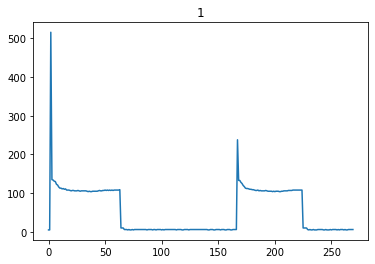

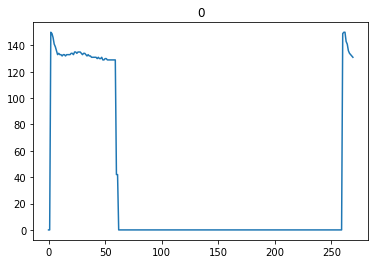

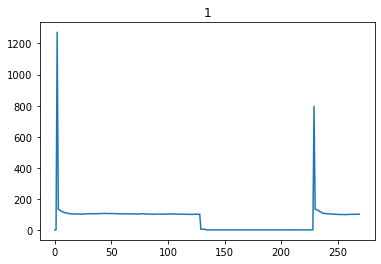

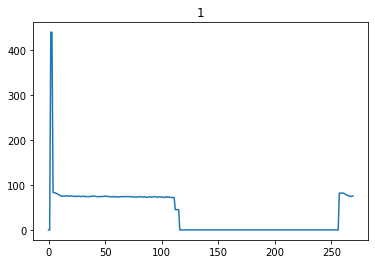

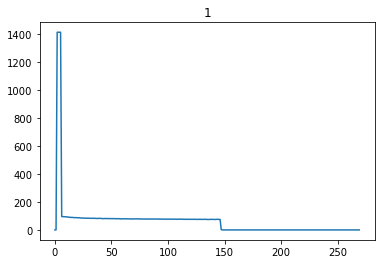

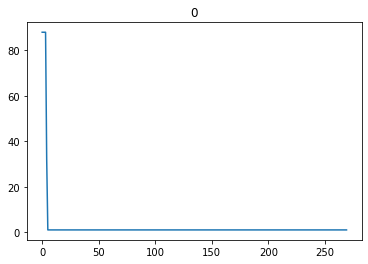

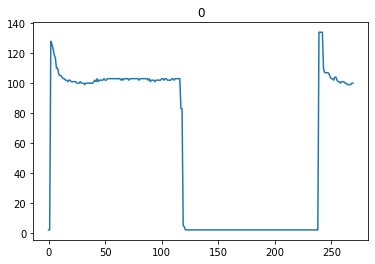

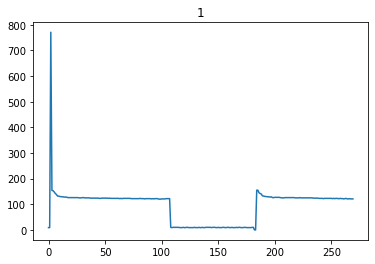

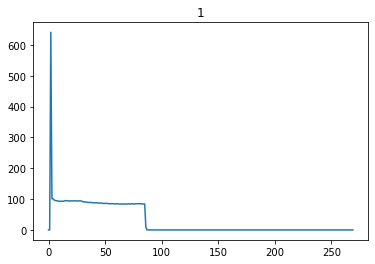

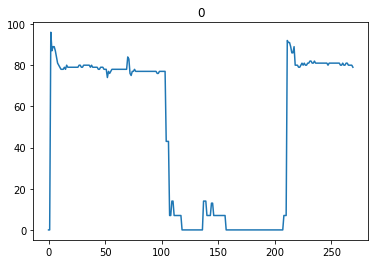

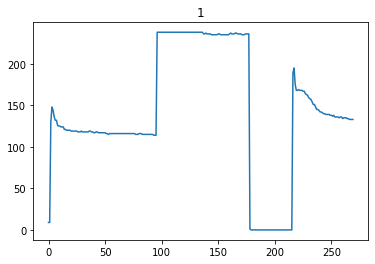

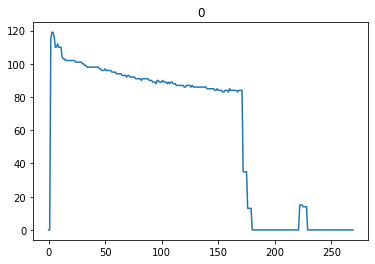

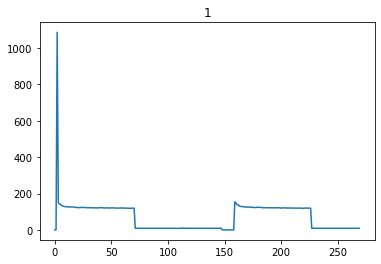

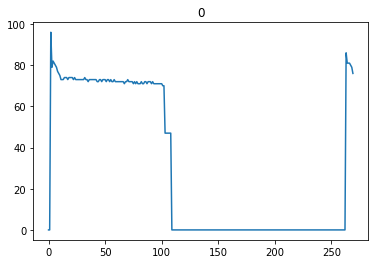

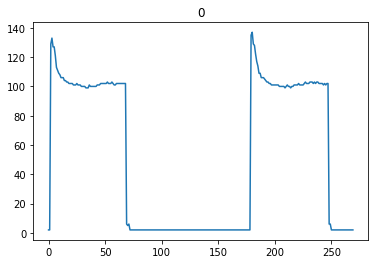

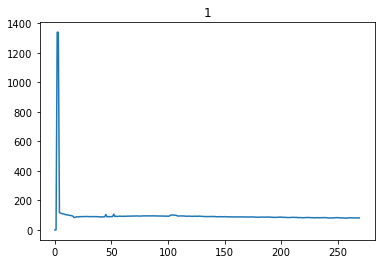

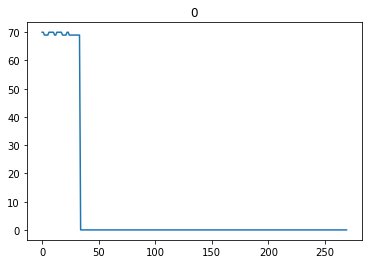

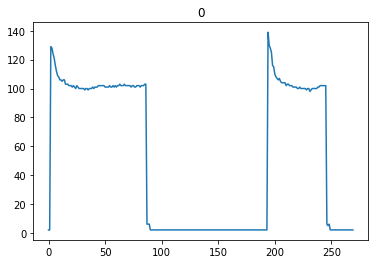

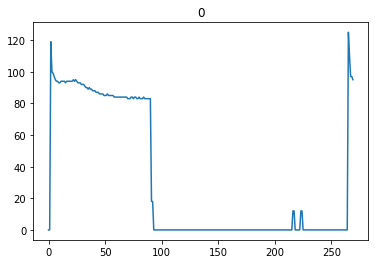

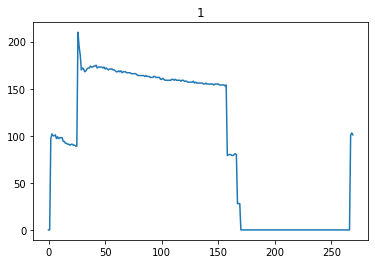

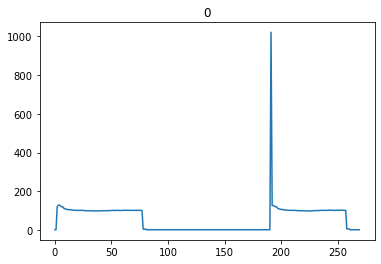

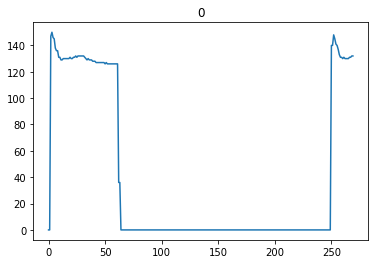

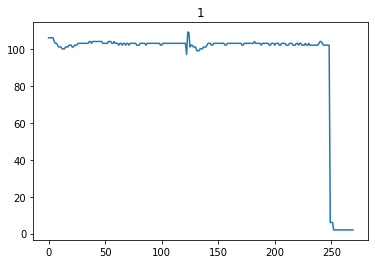

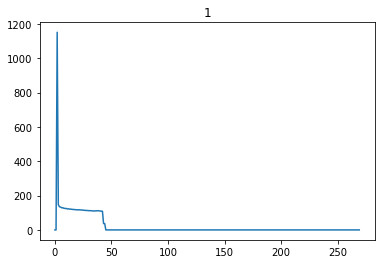

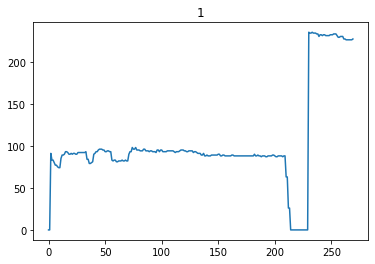

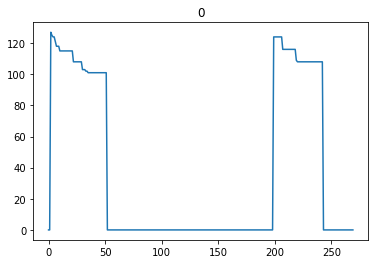

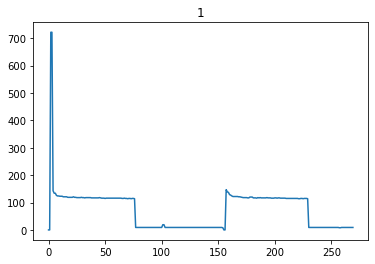

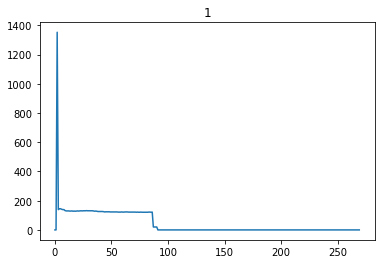

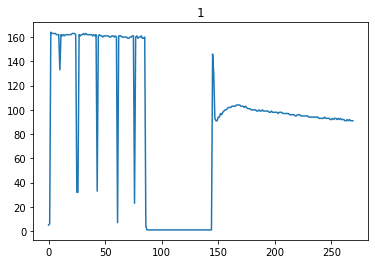

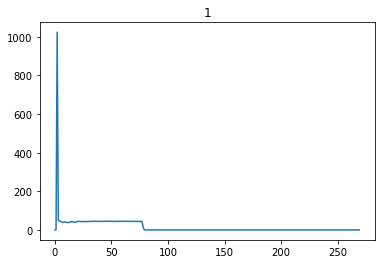

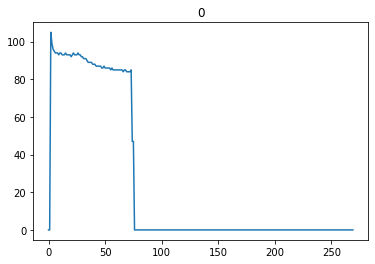

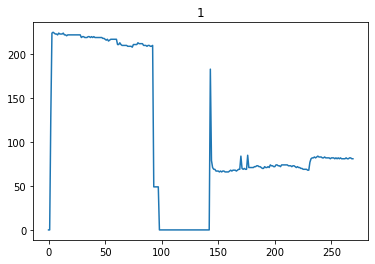

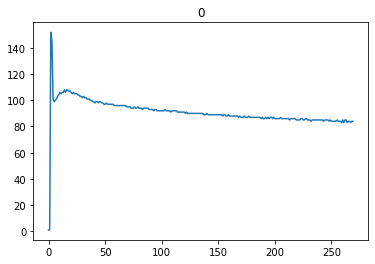

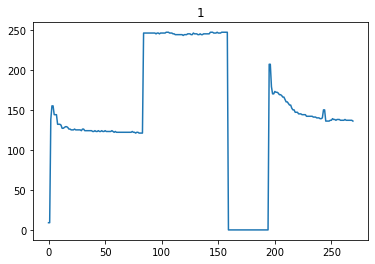

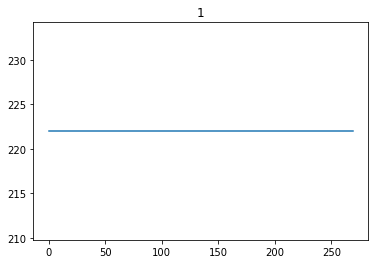

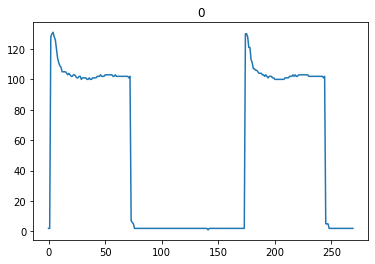

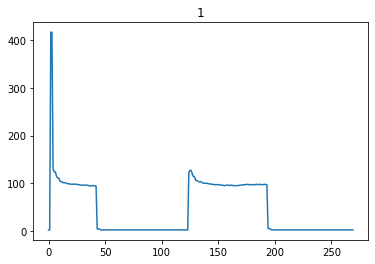

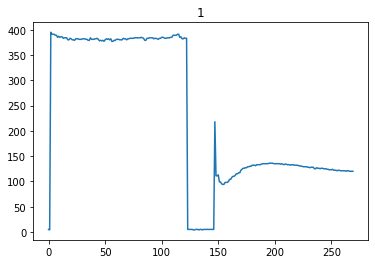

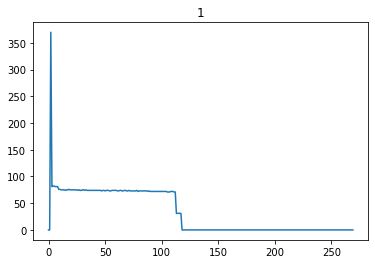

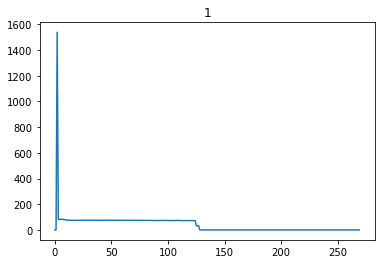

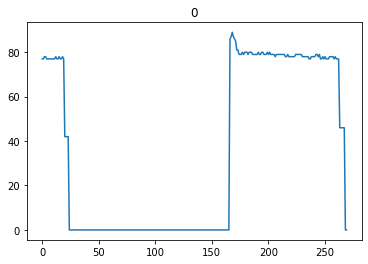

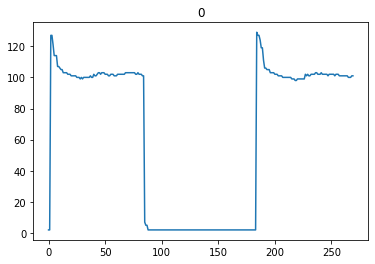

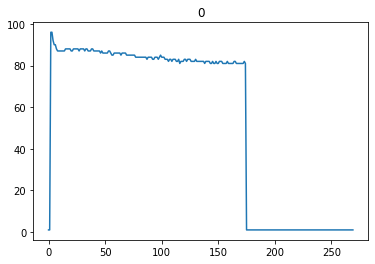

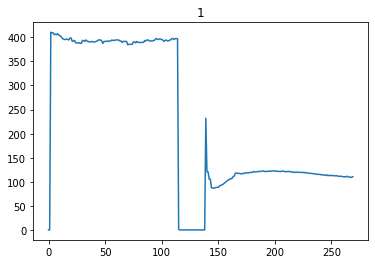

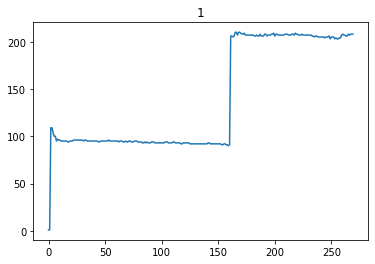

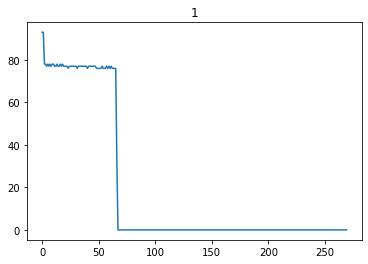

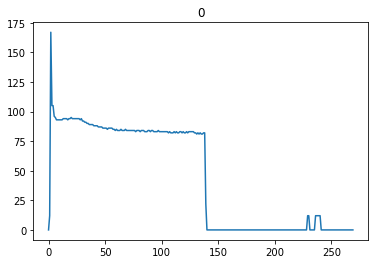

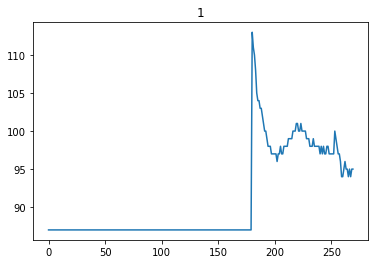

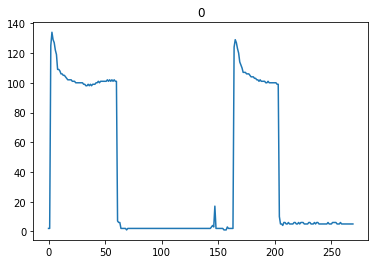

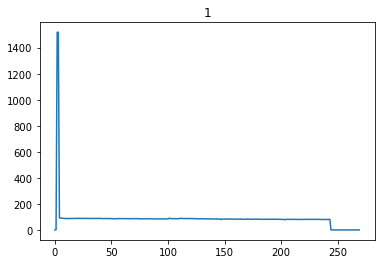

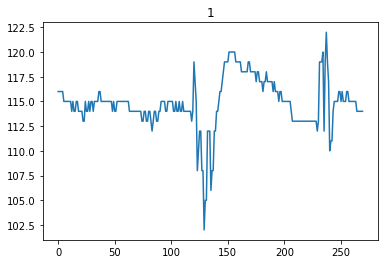

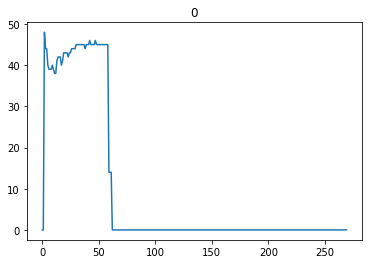

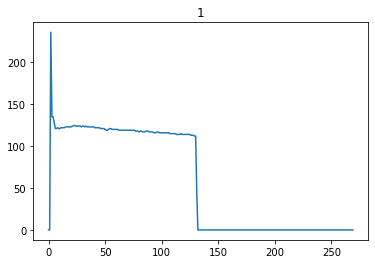

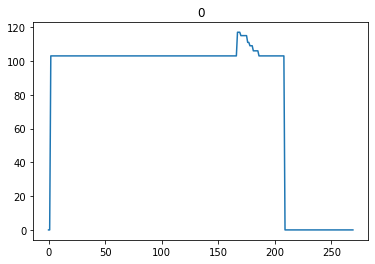

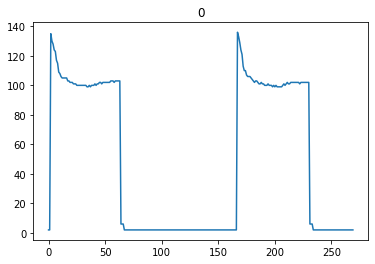

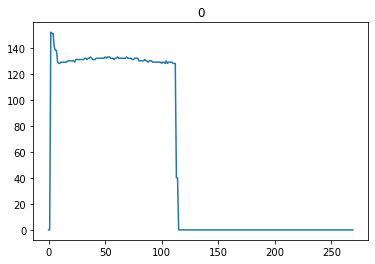

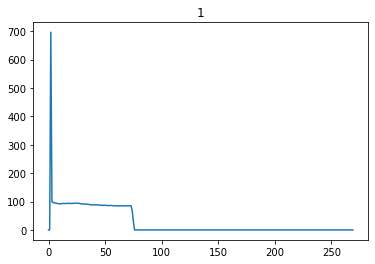

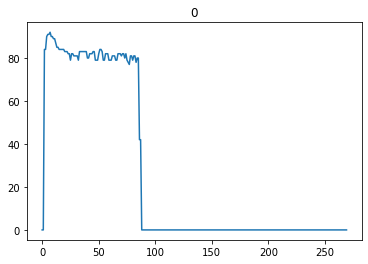

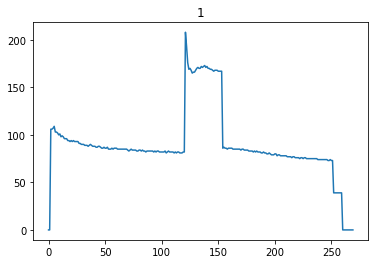

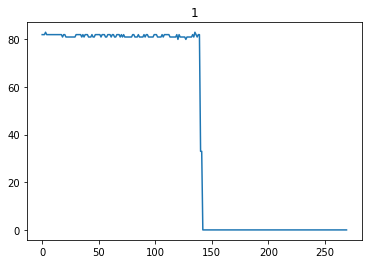

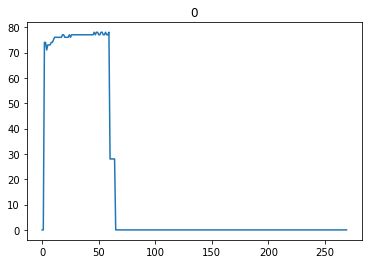

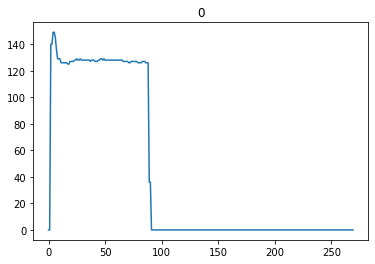

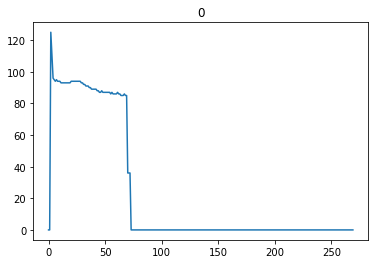

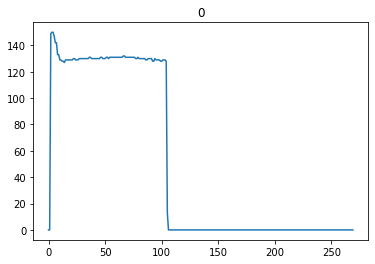

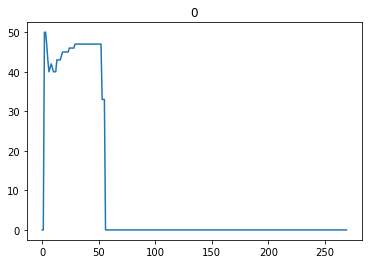

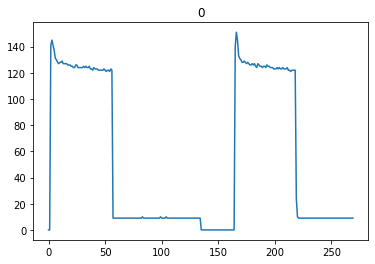

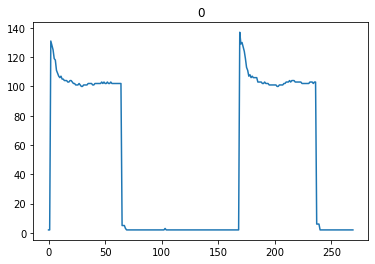

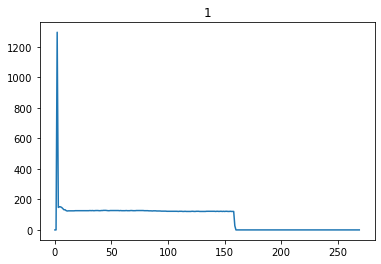

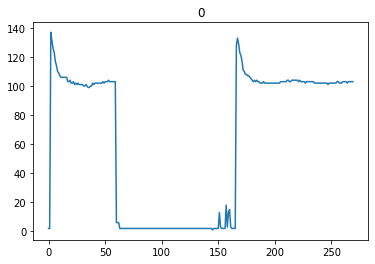

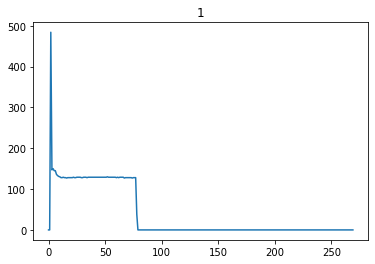

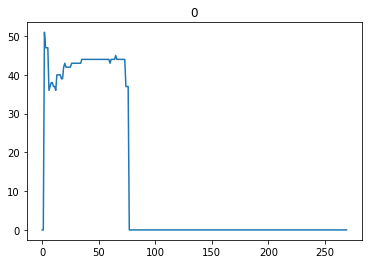

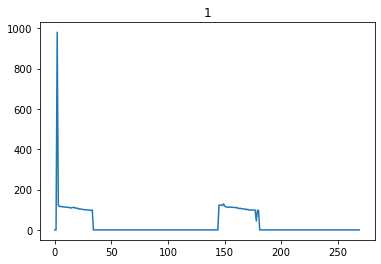

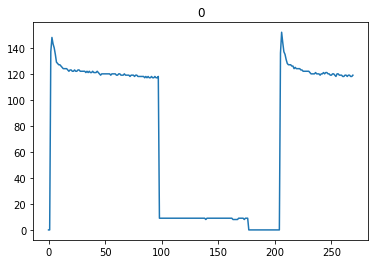

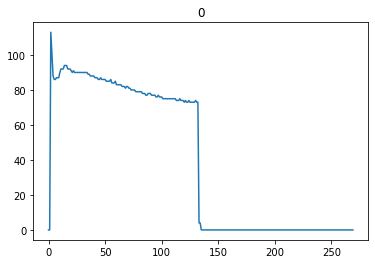

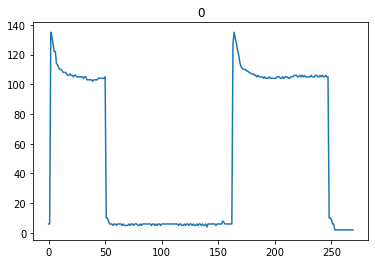

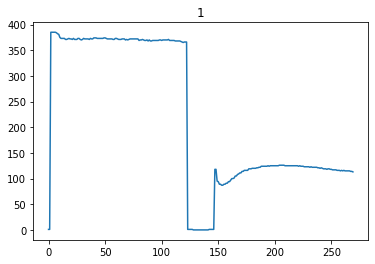

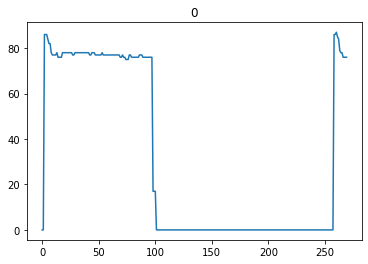

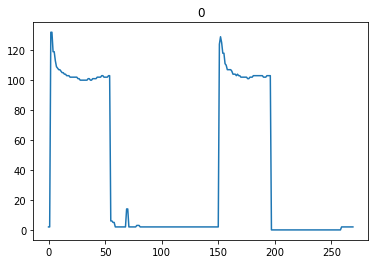

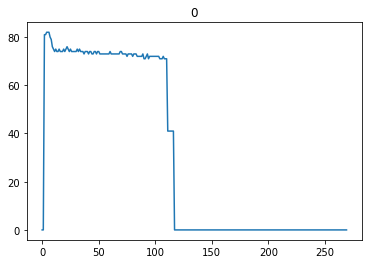

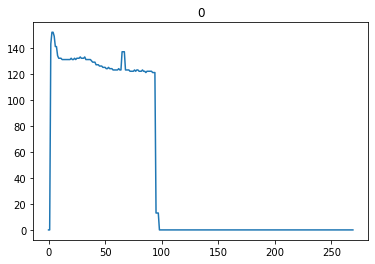

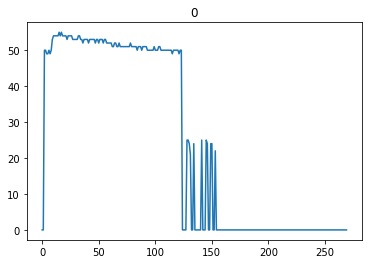

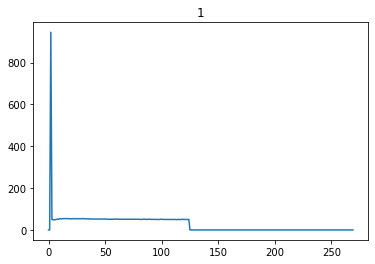

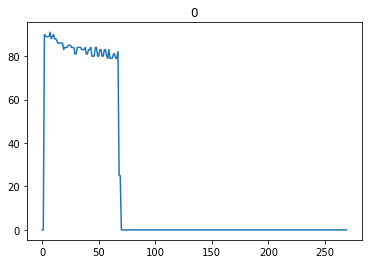

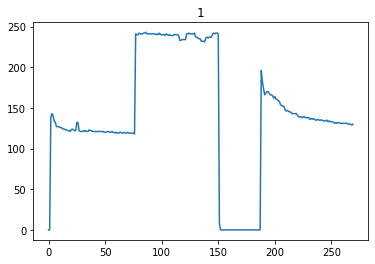

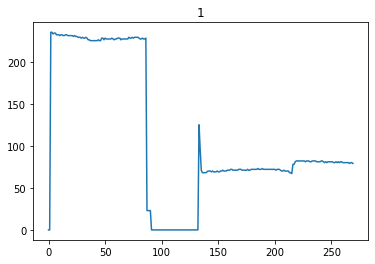

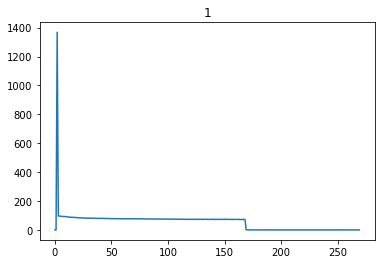

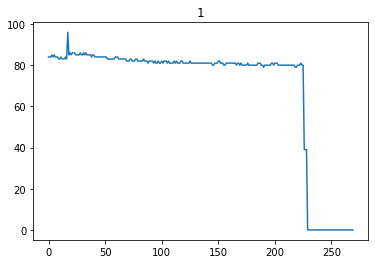

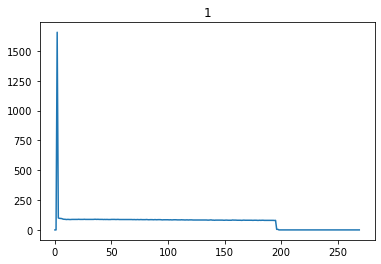

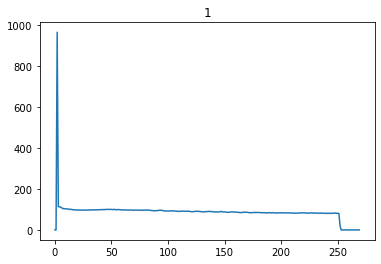

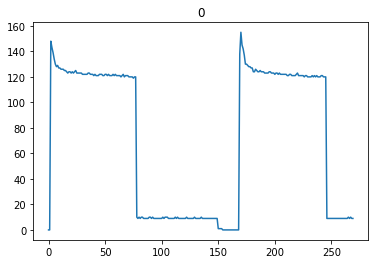

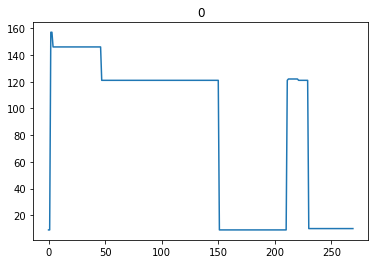

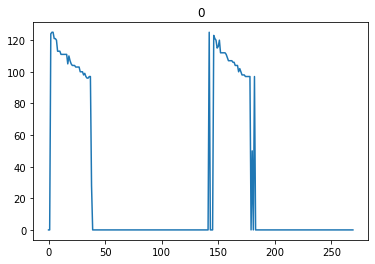

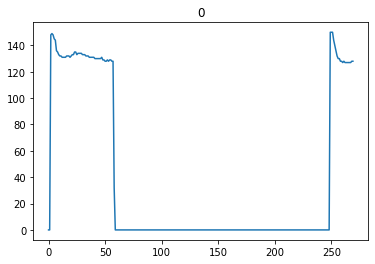

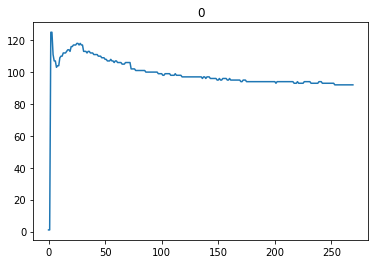

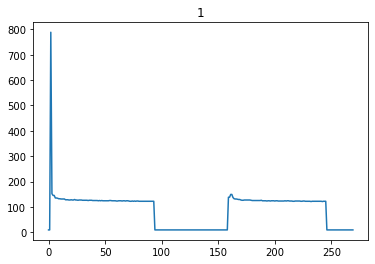

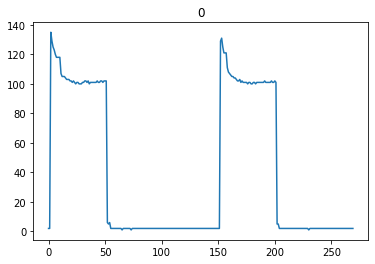

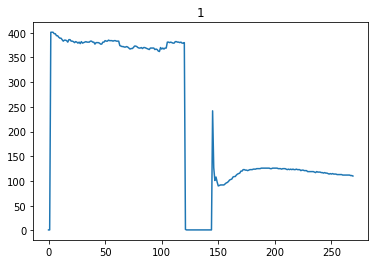

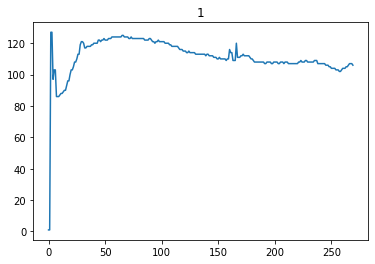

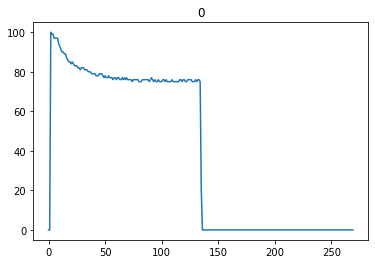

In [ ]:
activations=random.sample(range(0, len(x_train_refit)),1000)

for i in activations[0:100]:
    plt.figure()
    plt.plot(x_train_refit[i])
    plt.title(y_train_refit[i])
    